**Задание:** Обучить графовую нейронную сеть на молекулах и сравнить результаты с предыдущими сетями.

In [ ]:
# general tools
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Crippen import MolLogP
# Pytorch and Pytorch Geometric
import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, GCNConv, aggr, pool
from torch_geometric.data import DataLoader as PGDataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding


def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)


def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)


def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in tqdm(zip(x_smiles, y), total=len(x_smiles)):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [3]:
df = pd.read_csv('./dataset_v1.csv', nrows=10000)

In [4]:
logp = [MolLogP(Chem.MolFromSmiles(x)) for x in df.SMILES]

In [5]:
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(df['SMILES'], logp)

100%|██████████| 10000/10000 [00:14<00:00, 691.06it/s]


In [6]:
#smiles_mol = df.SMILES[0]
smiles_mol = "O=O"
print(smiles_mol)
print(MolLogP(Chem.MolFromSmiles(smiles_mol)))
mol = Chem.MolFromSmiles(smiles_mol)
n_nodes = mol.GetNumAtoms()
n_edges = 2*mol.GetNumBonds()
print(n_nodes)
print(n_edges)
unrelated_smiles = "O=O"
unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))
print(n_node_features)
print(n_edge_features)
atom = unrelated_mol.GetAtomWithIdx(0)
permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As',
                            'Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se',
                            'Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr',
                            'Pt','Hg','Pb','Unknown']
atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
print(atom_type_enc)
n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
print(n_heavy_neighbors_enc)
formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
print(formal_charge_enc)
hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
print(hybridisation_type_enc)
is_in_a_ring_enc = [int(atom.IsInRing())]
print(is_in_a_ring_enc)
is_aromatic_enc = [int(atom.GetIsAromatic())]
print(is_aromatic_enc)
atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
print(atomic_mass_scaled)
vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
print(vdw_radius_scaled)
covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]
print(covalent_radius_scaled)
atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
print(atom_feature_vector)

X = np.zeros((n_nodes, n_node_features))
for atom in unrelated_mol.GetAtoms():
    X[atom.GetIdx(), :] = get_atom_features(atom)
X = torch.tensor(X, dtype = torch.float)
print(X)

O=O
0.067
2
2
79
10
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0]
[0]
[0]
[0.04468008131481929]
[0.08333333333333341]
[0.05263157894736847]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.04468008131481929, 0.08333333333333341, 0.05263157894736847]
tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.

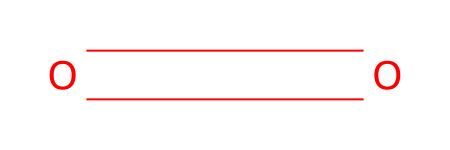

In [7]:
mol

In [8]:
train = []
test = []
test_scaffolds = []

In [9]:
for sid, split in enumerate(df.SPLIT):
    if split == 'train':
        train.append(data_list[sid])
    elif split == 'test':
        test.append(data_list[sid])
    else:
        test_scaffolds.append(data_list[sid])

In [10]:
torch.save([train, test, test_scaffolds], "moses_pg_splits")

In [11]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(79, 32)
        self.conv2 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 1)
        self.mean_pooling = pool.global_mean_pool

    def forward(self, data):
        x, edge_index= data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = self.mean_pooling(x, data.batch)
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        return x

In [12]:
batch_size = [5, 10, 20]
learning_rate = [0.1, 0.01, 0.001]

In [13]:
df_result = pd.DataFrame(columns=['batch_size', 'learning_rate', 'losses', 'losses_test', 'losses_test_scaf'])

for bs in batch_size:
    for lr in learning_rate:

        gnn_model = GCN().to(device)

        # canonical training loop for a Pytorch Geometric GNN model gnn_model

        # create list of molecular graph objects from list of SMILES x_smiles and list of labels y
        #data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y)

        batch_size = bs

        # create dataloader for training
        train_dataloader = PGDataLoader(dataset = train, batch_size = batch_size)
        test_dataloader = PGDataLoader(dataset = test, batch_size = batch_size)
        test_scaffolds_dataloader = PGDataLoader(dataset = test_scaffolds, batch_size = batch_size)

        # define loss function
        loss_function = MSELoss()

        # define optimiser
        optimiser = torch.optim.Adam(gnn_model.parameters(), lr = lr)

        # loop over 10 training epochs
        for epoch in range(10):

            # set model to training mode
            gnn_model.train()
            losses = []
            # loop over minibatches for training
            for (k, batch) in tqdm(enumerate(train_dataloader), total = len(train) // 2**7):

                # compute current value of loss function via forward pass
                output = gnn_model(batch.to(device))
                loss_function_value = loss_function(output[:,0], batch.y)
                losses.append(loss_function_value.detach().cpu())
                # set past gradient to zero
                optimiser.zero_grad()

                # compute current gradient via backward pass
                loss_function_value.backward()

                # update model weights using gradient and optimisation method
                optimiser.step()

            losses_test = []
            losses_test_scaffolds = []
    
            with torch.no_grad():

                for (k, batch) in tqdm(enumerate(test_dataloader), total = len(test) // 2**7):

                    # compute current value of loss function via forward pass
                    output = gnn_model(batch.to(device))
                    loss_function_value = loss_function(output[:,0], batch.y)
                    losses_test.append(loss_function_value.detach().cpu())


                for (k, batch) in tqdm(enumerate(test_scaffolds_dataloader), total = len(test_scaffolds) // 2**7):

                    # compute current value of loss function via forward pass
                    output = gnn_model(batch.to(device))
                    loss_function_value = loss_function(output[:,0], batch.y)
                    losses_test_scaffolds.append(loss_function_value.detach().cpu())
    
        df_result.loc[len(df_result.index)] = [bs, lr, np.mean(losses), np.mean(losses_test), np.mean(losses_test_scaffolds)]


c:\Users\ninag\mambaforge\envs\cc\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
1660it [00:10, 157.00it/s]                     
177it [00:00, 396.50it/s]            
164it [00:00, 385.50it/s]            
1660it [00:09, 183.72it/s]                      
177it [00:00, 392.09it/s]            
164it [00:00, 406.56it/s]            
1660it [00:08, 185.14it/s]                      
177it [00:00, 397.90it/s]            
164it [00:00, 379.21it/s]            
1660it [00:09, 181.78it/s]                      
177it [00:00, 385.10it/s]            
164it [00:00, 393.09it/s]            
1660it [00:09, 183.69it/s]                      
177it [00:00, 380.94it/s]            
164it [00:00, 398.08it/s]            
1660it [00:09, 181.96it/s]                      
177it [00:00, 393.85it/s]            
164it [00:00, 378.28it/s]            
1660it [00:09, 174.74it/s]                      
177it [00:00, 37

#### Результаты

In [14]:
df_result.sort_values(by=['losses_test']).head(5)

,batch_size,learning_rate,losses,losses_test,losses_test_scaf
5,10.0,0.001,0.157278,0.187816,0.163711
2,5.0,0.001,0.149492,0.232287,0.185060
8,20.0,0.001,0.180631,0.237158,0.196225
7,20.0,0.010,0.173617,0.259123,0.252588
1,5.0,0.010,0.191999,0.281196,0.233514


GCN при параметрах batch_size = 10 и learning_rate = 0.001 показала ошибку равную 0.19, что являестя самым плохим результатом из сетей на фингерпринтах и RNN. Вероятно, это ствязано с количеством эпох, при их увеличении ошибка снижается, однако время обучения сильно повышается.